In [1]:
import sys
from abc import ABC, abstractmethod

import numpy as np
from scipy import optimize
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy as sp
import scanpy as scp
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import random
import operator


import pandas as pd
import harmonypy as hm
from time import time
import seaborn as sns
import string

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

from scipy.io import mmread
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
import umap
from itertools import permutations

import logging

import anndata



import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

/Users/sagniknandy/miniconda3/envs/AMP_all_projects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


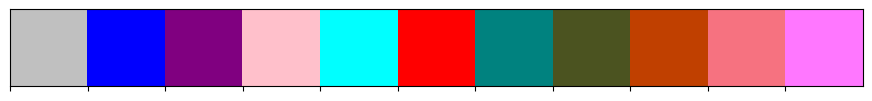

In [2]:
my_favourote_palette = ['#C0C0C0','#0000FF','#800080','#FFC0CB','#00FFFF','#FF0000','#00827F','#4B5320','#C04000','#F67280','#FF77FF']
sns.palplot(sns.color_palette(my_favourote_palette))
customPalette = sns.set_palette(sns.color_palette(my_favourote_palette))

In [3]:
def nearPSD(A,epsilon=0):
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,1e-4))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

In [4]:
def invreg(original_matrix, epsilon=1e-3):
    """
    Invert a matrix with regularization to avoid singularity.

    Parameters:
    - original_matrix: Input matrix to be inverted.
    - epsilon: Small value for regularization.

    Returns:
    - inverted_matrix: Inverted matrix.
    """

    # Adding a small diagonal matrix to avoid singularity
    diagonal_matrix = epsilon * np.eye(original_matrix.shape[0])
    regularized_matrix = original_matrix + diagonal_matrix

    # Invert the regularized matrix
    inverted_matrix = np.linalg.inv(regularized_matrix)

    return inverted_matrix

In [5]:
def replace_zeros_with_small_number(array, small_number=1e-30):
    """
    Replace zero values in a NumPy array with a very small number.

    Parameters:
    - array: NumPy array.
    - small_number: The small number to replace zero values with. Default is 1e-10.

    Returns:
    - Modified NumPy array with zero values replaced.
    """
    array[array == 0] = small_number
    return array

In [6]:
def fit_gmm(data, n_components, M, D):
    current_state = random.getstate()
    n_features = data.shape[1]
    inv_m = np.linalg.inv(M)
    gmm = GaussianMixture(n_components=n_components, max_iter=500)
    gmm.fit(data)
    means_unadjusted = gmm.means_
    means = means_unadjusted @ np.linalg.inv(M)
    adjusted_covariances = gmm.covariances_- D
    #covariances = np.array([nearPSD(inv_m @ cov @ inv_m.T) for cov in adjusted_covariances])
    traces = np.array([np.trace(cov_matrix) for cov_matrix in adjusted_covariances])
    positive_traces = np.maximum(traces, 0)
    adj_cov_factor = np.trace(M @ M.T)
    covariances_cons = positive_traces / adj_cov_factor
    covariances = np.array([cov * np.eye(n_features) for cov in covariances_cons])
    random.setstate(current_state)
    return means, covariances, gmm.weights_

In [7]:
def _get_W_gmm(data, m_prior, cov_prior, M, D, weights):


    num_components = len(weights)
    num_subjects = data.shape[0]
    responsibilities = np.zeros((num_components, num_subjects))
    
    # Convert the modality specific loadings to combined block diagonal matrices
    M_bd = sp.linalg.block_diag(*M)
    sigma_bd = sp.linalg.block_diag(*D)
    
    for components in range(num_components):
        mz = m_prior[components,:] @ M_bd.T
        matrix_to_cov = sigma_bd + M_bd @ cov_prior[components] @ M_bd.T
        covInv = np.linalg.inv(matrix_to_cov)
        
        _, logdet = np.linalg.slogdet(matrix_to_cov)
        
        fsq = (np.einsum("ik,ik -> i", data @ covInv, data) / 2)[:,np.newaxis]
        zsq = (mz.T @ covInv @ mz) / 2
        fz = np.array(data @ covInv @ mz)[:,np.newaxis]
        
        unscaled_weights = np.array(np.exp(np.clip(- fsq + fz - zsq - 0.5 * logdet,-700,700))).T
        del mz
         
        responsibilities[components,:] = weights[components] * unscaled_weights
    
    
    responsibilities = replace_zeros_with_small_number(responsibilities.T)
    
    total_responsibilities = np.log(np.sum(responsibilities, axis=1, keepdims = True))
    total_responsibilities[np.isneginf(total_responsibilities)] = -700
     
    responsibilities = np.log(responsibilities)
    responsibilities[np.isneginf(responsibilities)] = -700

    responsibilities = responsibilities - total_responsibilities
      
    #print(f"The current estimated responsibility is {responsibilities}")
    return(np.exp(responsibilities))

In [8]:
def denoise_gmm(data, m_prior, cov_prior, M, D, weights): 
    
    num_components = len(weights)
    num_samples, num_features = data.shape
    
    # Iteratively compute and average component posterior means

    P = _get_W_gmm(data, m_prior, cov_prior, M, D, weights)

    M = sp.linalg.block_diag(*M)
    D = sp.linalg.block_diag(*D)


    result = np.zeros((num_samples, num_features))
    inv_D = np.linalg.inv(D)
    inv_cov_prior = np.array([np.linalg.pinv(cov_matrix) for cov_matrix in cov_prior])

    
    for comp in range(num_components):

        adj_scaling = np.linalg.inv(M.T @ inv_D @ M + inv_cov_prior[comp])
        denoised_part_data = data @ inv_D.T @ M @ adj_scaling.T
        denoised_part_prior = m_prior[comp,:] @ inv_cov_prior[comp].T @ adj_scaling.T
        weights_to_mult = P[:,comp]
        denoised_whole = denoised_part_data + denoised_part_prior
        denoised_whole = denoised_whole *  weights_to_mult[:,np.newaxis]
        result = result + denoised_whole
        
    return result

In [9]:
def ddenoise_gmm(data, m_prior, cov_prior, M, D, weights):

    num_components = len(weights)
    num_samples, num_features = data.shape
    
    # Iteratively compute and average component posterior means
    
    P = _get_W_gmm(data, m_prior, cov_prior, M, D, weights)

    M = sp.linalg.block_diag(*M)
    D = sp.linalg.block_diag(*D)
    
    result_1 = np.zeros((num_samples, num_features, num_features))
    
    matrix_1 = np.zeros((num_components, num_samples, num_features))
    matrix_2 = np.zeros((num_components, num_samples, num_features))
    matrix_3 = np.zeros((num_components, num_features, num_features))

    inv_D = np.linalg.inv(D)
    inv_cov_prior = np.array([np.linalg.pinv(cov_matrix) for cov_matrix in cov_prior])

    
    
    for comp in range(num_components):
        precision = np.linalg.inv(M.T @ inv_D @ M + inv_cov_prior[comp])
        adj_mat = np.linalg.inv(D + M @ cov_prior[comp] @ M.T)
        matrix_1[comp] = (data @ inv_D @ M + m_prior[comp,:] @ inv_cov_prior[comp]) @ precision.T
        matrix_2[comp] = (data - m_prior[comp,:] @ M.T) @ adj_mat.T
        matrix_3[comp] = precision @ M.T @ inv_D
    
    
    for comp in range(num_components):
        outer_prod = np.einsum('ij,ik->ijk', matrix_1[comp], matrix_2[comp]) - matrix_3[comp]
        weight = P[:,comp].flatten()
        result_1 = result_1 - outer_prod * weight[:, np.newaxis, np.newaxis]
    
    for comp_1 in range(num_components):
        for comp_2 in range(num_components):
            outer_prod = np.einsum('ij,ik->ijk', matrix_1[comp_1], matrix_2[comp_2])  
            weight = P[:,comp_1].flatten() * P[:,comp_2].flatten()
            result_1 = result_1 + outer_prod * weight[:, np.newaxis, np.newaxis]   
        
    return(result_1)    

## Utils Function

In [10]:
matrix_outer = lambda A, B: np.einsum("bi,bo->bio", A, B)

In [11]:
def machineEpsilon(func=float):
    machine_epsilon = func(1)
    while func(1)+func(machine_epsilon) != func(1):
        machine_epsilon_last = machine_epsilon
        machine_epsilon = func(machine_epsilon) / func(2)
    return machine_epsilon_last

In [12]:
# Creates a UMAP visualization of high dimensional data
## Input: Feature set, labels, colors of clusters
## Output: UMAP plot

def umap_visualize(arr, labels, palette="hls"):
    u = umap.UMAP().fit_transform(
        arr
    )
    umap_data = pd.DataFrame({'u0': u[:, 0], 'u1': u[:, 1], 'label': labels})
    sns.scatterplot(data=umap_data, x='u0', y='u1', hue='label', palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [13]:
# Obtains misclassicfication error with respect to a given clustering
## Input: number of clusters, true clusters, estimated clusters
## Output: misclassification error

def misclassification_rate(k, sigma, sigmahat):
    # given two clustering of length p sigma(i) in {0, 1, ..., k-1}
    # return their misclassification rate up to permutation
    # k is the number of clusters
    p = len(sigma)
    res = 1
    new_sigma = [0] * p
    for perm in permutations(range(k)):
        for i in range(p):
            new_sigma[i] = perm[sigmahat[i]]
        cur = sum(a != b for a, b in zip(sigma, new_sigma))
        res = min(res, cur/p)
    return res

In [14]:
# Fits K-Means and obtains labels for a set of features
## Input: Feature Matrix, number of clusters
## Output: k means labels

def get_kmeans_label(feature, k = 2):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature)
    kmeans = KMeans(
        init = "random",
        n_clusters = k,
        n_init = 10,
        max_iter = 300,
        random_state = 42
        )
    kmeans.fit(scaled_features)
    return kmeans.labels_

In [15]:
# Computes robust SVD
## Input: Features, number of singular values
## Output: Singular vectors and Values

def robust_svd(arr, n_components, randomized=False, n_runs=1):
    """
    Do deterministic or randomized SVD on arr.
    Parameters
    ----------
    arr: np.array
        The array to do SVD on
    n_components: int
        Number of SVD components
    randomized: bool, default=False
        Whether to run randomized SVD
    n_runs: int, default=1
        Run multiple times and take the realization with the lowest Frobenious reconstruction error

    Returns
    -------
    u, s, vh: np.array
        u @ np.diag(s) @ vh is the reconstruction of the original arr
    """
    if randomized:
        best_err = float('inf')
        u, s, vh = None, None, None
        for _ in range(n_runs):
            curr_u, curr_s, curr_vh = randomized_svd(arr, n_components=n_components, random_state=None)
            curr_err = np.sum((arr - curr_u @ np.diag(curr_s) @ curr_vh) ** 2)
            if curr_err < best_err:
                best_err = curr_err
                u, s, vh = curr_u, curr_s, curr_vh
        assert u is not None and s is not None and vh is not None
    else:
        if n_runs > 1:
            warnings.warn("Doing deterministic SVD, n_runs reset to one.")
        u, s, vh = svds(arr*1.0, k=n_components) # svds can not handle integer values
    return u, s, vh

In [16]:
# Divides a row by its sum and sclaes it to a reference value
## Input: Frow to be sclaed, reference value
## Output: scaled row

def normalize_vector(v, scale_factor):
    return (v / np.sum(v)) * scale_factor

In [17]:
# Normalizes given cell by features matrix to remove sequencing depth irregularities
## Input: Matrix to be normalized and scaled
## Output: Normalized matrix

def normalize_data_matrix(A, scale_factor):
    A_temp = np.apply_along_axis(normalize_vector, 1, A, scale_factor)  
    A_temp = np.apply_along_axis(np.log1p, 1, A_temp)
    return A_temp

In [18]:
# -------------------------
# Utilities
# -------------------------
def clr_per_cell(A, pseudocount=1.0, clip=None):
    """
    Per-cell CLR for ADT counts.
    A: (n_cells x n_proteins) nonnegative counts array
    pseudocount: add before log to handle zeros (use 1.0 for ADTs)
    clip: optional float to clip final values to [-clip, clip]
    """
    L = np.log(A + pseudocount)            # or np.log1p(A) if pseudocount=1
    L_mean = L.mean(axis=1, keepdims=True) # per-cell mean log
    Z = L - L_mean                          # CLR
    if clip is not None:
        Z = np.clip(Z, -clip, clip)
    return Z

def robust_scale_features(X):
    """
    Feature-wise robust scaling across cells: (x - median)/MAD.
    Fallback to std if MAD is ~0. Returns scaled X and per-feature stats.
    """
    med = np.median(X, axis=0, keepdims=True)
    mad = np.median(np.abs(X - med), axis=0, keepdims=True)
    # Avoid divide-by-zero: fallback to std where MAD is tiny
    fallback = (mad < 1e-8).ravel()
    Xs = np.empty_like(X)
    if np.any(~fallback):
        Xs[:, ~fallback] = (X[:, ~fallback] - med[:, ~fallback]) / (mad[:, ~fallback] + 1e-12)
    if np.any(fallback):
        mu = X[:, fallback].mean(axis=0, keepdims=True)
        sd = X[:, fallback].std(axis=0, keepdims=True) + 1e-12
        Xs[:, fallback] = (X[:, fallback] - mu) / sd
    return Xs

In [19]:
### Corrects Singular Values

def _convert_singular_val(y, gamma):
    under_sqrt = (gamma * y ** 2 - (1 + gamma)) ** 2 - 4 * gamma
    t = np.zeros(len(under_sqrt))
    where_positive = np.where(under_sqrt >= 0)[0]
    where_negative = np.where(under_sqrt < 0)[0]
    t[where_positive] = (gamma * y[where_positive] ** 2 - (1 + gamma) + np.sqrt(under_sqrt[where_positive]))/ (2 * gamma)
    t[where_negative] = y[where_negative] ** 2
    return np.sqrt(t)

In [20]:
# Generate support of the prior by k-means
## Input: feature matrix, number of clusters, mean
## Output: set of support points

def extract_support(feature, k, mu, do_k_means):
    if do_k_means == 0:
        support = feature.dot(np.linalg.pinv(mu).T)
        return support 
    else:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(feature)
        kmeans = KMeans(
         init = "random",
         n_clusters = k,
         n_init = 10,
         max_iter = 300,
         random_state = 42
         )
        kmeans.fit(scaled_features)
        cen = kmeans.cluster_centers_
        support = cen.dot(np.linalg.pinv(mu).T)
        return support

In [21]:
def sqrtmplaw(x, n_samples = 0, n_features = 0):
    '''we require the noise variance to be 1/n_samples
    '''
    aspect_ratio = n_features/n_samples
    lambda_plus = (1+np.sqrt(aspect_ratio))**2
    lambda_minus = (1 - np.sqrt(aspect_ratio))**2
    if x**2 < lambda_minus or x**2 > lambda_plus:
        return 0
    else: 
        return 1/(np.pi * aspect_ratio * x) * np.sqrt((lambda_plus - x**2)*(x**2 - lambda_minus))

def sqrtMPlaw(arr, n, p):
    return [sqrtmplaw(x, n, p) for x in arr]

## OrchAMP functions

In [22]:
# Generate weights corresponding to the support points rowwise
## Input: feature matrix, support points, mean, inverse covariance
## Output: weight matrix

def _get_W_single(f, z, mu, covInv):
    fsq = (np.einsum("ik,ik -> i", f @ covInv, f) / 2)[:,np.newaxis]
    mz = z.dot(mu.T)
    zsq = np.einsum("ik, ik->i", mz @ covInv, mz) / 2
    fz = f @ covInv @ mz.T
    del mz
    
    # Need to clip it if required
    return np.clip(np.exp(- fsq + fz - zsq),-700,700)

In [23]:
# EM algorithm to estimate NPMLE from weight matrix
## Input: feature matrix, support points, mean, inverse covariance, number of EM iterations
## Output: NPMLE....discrete probability distribution over the support points

def _npmle_em_hd_single(f, Z, mu, covInv, em_iter):
    # I dont need this n_dim
    nsupp = Z.shape[0]
    pi = np.array([1/nsupp] * nsupp)
    W = _get_W_single(f, Z, mu, covInv)
    
    Wt = np.array(W.T, order = 'C')
    for _ in range(em_iter):
        denom = W.dot(pi)# [:,np.newaxis] # denom[i] = \sum_j pi[j]*W[i,j]
        pi = pi * np.mean(Wt/denom, axis = 1)
    
    return pi

In [24]:
## Wrapper to estimate NPMLE 
## Input: feature matrix, support points, mean, covariance, number of EM iterations
## Output: NPMLE....discrete probability distribution over the support points

def estimate_prior_single(f, Z, mu, cov, em_iter):
    covInv = np.linalg.inv(cov)
    return _npmle_em_hd_single(f, Z, mu, covInv, em_iter)

In [25]:
# Posterior probability matrix
## Input: feature matrix, support points, mean, inverse covariance, prior probabilities
## Output: Posterior probability matrix

def _get_P_single(f, z, mu, covInv, pi):
    W = _get_W_single(f , z, mu, covInv)
    denom = W.dot(pi) # denom[i] = \sum_j pi[j] * W[i,j]
    num = W * pi # W*pi[i,j] = pi[j] * W[i,j]
    return num / denom[:, np.newaxis]

In [26]:
# Posterior probability matrix
## Input: feature matrix, support points, mean, inverse covariance, prior probabilities
## Output: Posterior probability matrix

def _get_P_single_modified(f, z, mu, covInv, pi):
    W = _get_W_single(f , z, mu, covInv)
    denom = np.log(W.dot(pi)) # denom[i] = \sum_j pi[j] * W[i,j]
    num = np.log(W * pi) # W*pi[i,j] = pi[j] * W[i,j]
    value = num - denom[:, np.newaxis]
    return np.exp(value)

In [27]:
# Denoiser: posterior mean
## Input: support points, feature matrix, mean, covariance, prior probabilities
## Output: Posterior probability matrix

def denoise_single(Z, f, mu, cov, pi):
        covInv = np.linalg.inv(cov)
        P = _get_P_single(f, Z, mu, covInv, pi)
        return P @ Z 

In [28]:
# Derivative of the denoiser
## Input: support points, feature matrix, mean, covariance, prior probabilities
## Output: Derivative of the denoiser

def ddenoise_single(Z, f, mu, cov, pi):
        covInv = np.linalg.inv(cov)
        P = _get_P_single(f, Z, mu, covInv, pi)
        ZouterMZ = np.einsum("ijk, kl -> ijl" ,matrix_outer(Z, Z.dot(mu.T)), covInv) 
        E1 = np.einsum("ij, jkl -> ikl", P, ZouterMZ)
        E2a = P @ Z # shape (I * rank)
        E2 = np.einsum("ijk, kl -> ijl" ,matrix_outer(E2a, E2a.dot(mu.T)), covInv)  # shape (I * rank)
        return E1 - E2

In [29]:
# Generate weights corresponding to the support points rowwise from two different feature matrices
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, mean_1, inverse covariance_1, mean_2, inverse covariance_2
## Output: weight matrix

def _get_W_joint(f_x, z_x, f_y, z_y, mu_x, mu_y, covInv_x, covInv_y):
    fsq_x = (np.einsum("ik,ik -> i", f_x @ covInv_x, f_x) / 2)[:,np.newaxis]
    mz_x = z_x.dot(mu_x.T)
    zsq_x = np.einsum("ik, ik->i", mz_x @ covInv_x, mz_x) / 2
    fz_x = f_x @ covInv_x @ mz_x.T
    del mz_x
    fsq_y = (np.einsum("ik,ik -> i", f_y @ covInv_y, f_y) / 2)[:,np.newaxis]
    mz_y = z_y.dot(mu_y.T)
    zsq_y = np.einsum("ik, ik->i", mz_y @ covInv_y, mz_y) / 2
    fz_y = f_y @ covInv_y @ mz_y.T
    del mz_y
    return np.exp(np.clip(- fsq_x + fz_x - zsq_x - fsq_y + fz_y - zsq_y,-700,700))

In [30]:
# EM algorithm to estimate NPMLE from weight matrix
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, mean_1, inverse covariance_1, mean_2, inverse covariance_2
## Output: NPMLE....discrete probability distribution over the support points

def _npmle_em_hd_joint(f_x, Z_x, f_y, Z_y, mu_x, mu_y, covInv_x, covInv_y, em_iter):
    # I dont need this n_dim
    nsupp = Z_x.shape[0]
    pi = np.array([1/nsupp] * nsupp)
    W = _get_W_joint(f_x, Z_x, f_y, Z_y, mu_x, mu_y, covInv_x, covInv_y)

    Wt = np.array(W.T, order = 'C')
    for _ in range(em_iter):
        denom = W.dot(pi)# [:,np.newaxis] # denom[i] = \sum_j pi[j]*W[i,j]
        pi = pi * np.mean(Wt/denom, axis = 1)
    
    return pi

In [31]:
# Wrapper to estimate NPMLE 
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, mean_1, inverse covariance_1, mean_2, inverse covariance_2
## Output: NPMLE....discrete probability distribution over the support points

def estimate_prior_joint(f_x, f_y, Z_x, Z_y, mu_x, mu_y, cov_x, cov_y, em_iter):
    covInv_x = np.linalg.inv(cov_x)
    covInv_y = np.linalg.inv(cov_y)
    return _npmle_em_hd_joint(f_x, Z_x, f_y, Z_y, mu_x, mu_y, covInv_x, covInv_y, em_iter)

In [32]:
# Posterior probability matrix
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, mean_1, inverse covariance_1, mean_2, inverse covariance_2
## Output: Posterior probability matrix

def _get_P_joint(f_x, z_x, f_y, z_y, mu_x, covInv_x, mu_y, covInv_y, pi):
    W = _get_W_joint(f_x, z_x, f_y, z_y, mu_x, mu_y, covInv_x, covInv_y)
    denom = W.dot(pi) # denom[i] = \sum_j pi[j] * W[i,j]
    num = W * pi # W*pi[i,j] = pi[j] * W[i,j]
    return num / denom[:, np.newaxis]

In [33]:
# Denoiser: posterior mean of first co-ordinate
## Input: support points_1, feature matrix_1, support points_2, feature matrix_2, mean_1, mean_2, covariance_1, covariance_2, prior probabilities
## Output: Posterior probability matrix

def denoise_joint_x(Z_x, f_x, Z_y, f_y, mu_x, cov_x, mu_y, cov_y, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, mu_x, covInv_x, mu_y, covInv_y, pi)
        return P @ Z_x 

In [34]:
# Denoiser: posterior mean of second co-ordinate
## Input: support points_1, feature matrix_1, support points_2, feature matrix_2, mean_1, mean_2, covariance_1, covariance_2, prior probabilities
## Output: Posterior probability matrix

def denoise_joint_y(Z_x, f_x, Z_y, f_y, mu_x, cov_x, mu_y, cov_y, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, mu_x, covInv_x, mu_y, covInv_y, pi)
        return P @ Z_y

In [35]:
# Derivative of Denoiser: posterior mean of first co-ordinate
## Input: support points_1, feature matrix_1, support points_2, feature matrix_2, mean_1, mean_2, covariance_1, covariance_2, prior probabilities
## Output: Jacobian with respect to first set of co-ordinates

def ddenoise_joint_x(Z_x, f_x, Z_y, f_y, mu_x, cov_x, mu_y, cov_y, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, mu_x, covInv_x, mu_y, covInv_y, pi)
        ZouterMZ = np.einsum("ijk, kl -> ijl" ,matrix_outer(Z_x, Z_x.dot(mu_x.T)), covInv_x) 
        E1 = np.einsum("ij, jkl -> ikl", P, ZouterMZ)
        E2a = P @ Z_x # shape (I * rank)
        E2 = np.einsum("ijk, kl -> ijl" ,matrix_outer(E2a, E2a.dot(mu_x.T)), covInv_x)  # shape (I * rank)
        return E1 - E2

In [36]:
# Derivative of Denoiser: posterior mean of first co-ordinate
## Input: support points_1, feature matrix_1, support points_2, feature matrix_2, mean_1, mean_2, covariance_1, covariance_2, prior probabilities
## Output: Jacobian with respect to first set of co-ordinates

def ddenoise_joint_y(Z_x, f_x, Z_y, f_y, mu_x, cov_x, mu_y, cov_y, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, mu_x, covInv_x, mu_y, covInv_y, pi)
        ZouterMZ = np.einsum("ijk, kl -> ijl" ,matrix_outer(Z_y, Z_y.dot(mu_y.T)), covInv_y) 
        E1 = np.einsum("ij, jkl -> ikl", P, ZouterMZ)
        E2a = P @ Z_y # shape (I * rank)
        E2 = np.einsum("ijk, kl -> ijl" ,matrix_outer(E2a, E2a.dot(mu_y.T)), covInv_y)  # shape (I * rank)
        return E1 - E2

In [37]:
def bic_gmm_grid_search(data, k_min=1, k_max=10, random_state=None):
    bics = []
    models = []
    for k in range(k_min, k_max + 1):
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        gmm.fit(data)
        bics.append(gmm.bic(data))
        models.append(gmm)
    best_k = np.arange(k_min, k_max + 1)[np.argmin(bics)]
    best_model = models[np.argmin(bics)]
    return best_k, best_model, bics

In [38]:
seed = 10
np.random.seed(seed)
random.seed(seed)

## Data Preprocessing

In [39]:
## Read the protein data

data_protein = pd.read_csv('pro.csv', header=0, index_col=0, low_memory=False)
data_protein = pd.DataFrame(data_protein)
A_raw = data_protein.to_numpy()
A_raw = np.delete(A_raw, obj = 0, axis = 1)
A_raw = A_raw.astype('float64')
A_raw = A_raw

## CLR Normalization and Scaling  
## Determining the factor to scale the data 
scale_factor_A = round(np.median(A_raw.sum(axis = 1)), -3)
A_raw = normalize_data_matrix(A_raw, scale_factor_A)  

U_cpm, S_cpm, Vt_cpm = np.linalg.svd(A_raw, full_matrices=False)
k_est_cpm = 175
n_features_cpm_adt = A_raw.shape[1]
n_samples_cpm_adt = A_raw.shape[0]
A_cpm_residual = A_raw - (U_cpm[:, :k_est_cpm] @ np.diag(S_cpm[:k_est_cpm]) @ Vt_cpm[:k_est_cpm, :])
tau_sq_cpm = np.sum(A_cpm_residual**2) / (n_features_cpm_adt * n_samples_cpm_adt)

A_raw = A_raw / np.sqrt(tau_sq_cpm)


#A_raw = A_raw * np.sqrt(A_raw.shape[1])  # scale by sqrt(num_proteins) for stability  

## Compute protein wise variances

var_up_A = np.var(A_raw, axis=0)

## Reading and Processing Meta Data for Harmony Correction

meta_harmony = pd.read_csv('meta.csv', low_memory=False)
meta_harmony.columns =['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
vars_use = ['7']

## Harmony Correction to remove lane effect

U_A_raw, S_A_raw, V_A_raw = np.linalg.svd(A_raw, full_matrices = False)
harmony_matrix_A = U_A_raw @ np.diag(S_A_raw)
ho_A = hm.run_harmony(harmony_matrix_A, meta_harmony, vars_use)
updated_pcs_A = np.array(ho_A.Z_corr).T
A = updated_pcs_A @ V_A_raw



2025-11-17 13:41:02,325 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-17 13:41:04,558 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-17 13:41:04,585 - harmonypy - INFO - Iteration 1 of 10
2025-11-17 13:41:05,528 - harmonypy - INFO - Iteration 2 of 10
2025-11-17 13:41:06,382 - harmonypy - INFO - Iteration 3 of 10
2025-11-17 13:41:07,189 - harmonypy - INFO - Converged after 3 iterations


In [40]:
## Collect top 30 highly variable proteins

topk = 30

var_A = np.var(A, axis = 0)
ind = np.argpartition(var_A, -topk)[-topk:]

ind_to_save = pd.DataFrame(ind)
ind_to_save.to_csv('/Users/sagniknandy/Library/CloudStorage/Dropbox/PhD Projects/Current_Projects_with_Seniors/AMP+Multimodal_Data/Data_codes_cmp_norm/Cite_seq_detailed_ablation/indices_of_highly_variable_protein.csv')

A = A[:,ind]


## Centering A

mean_A = np.mean(A, axis=0)
A = A - mean_A
k_A = A.shape[1]


In [41]:
data_mofa_protein = pd.DataFrame(A)
data_mofa_protein.to_csv('data_mofa_protein.csv')

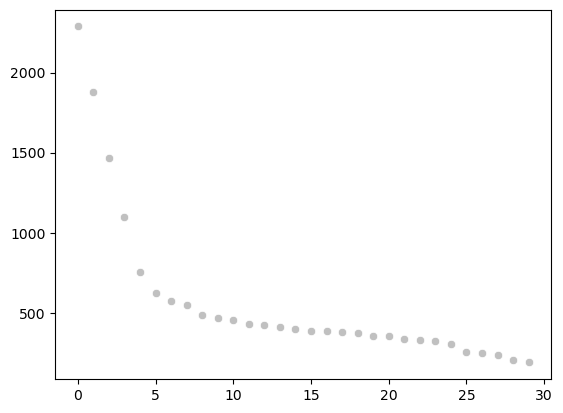

In [42]:
## Studying the dominant atac PC's

U1_init_ad, S1_init_ad, V1_init_ad = np.linalg.svd(A, full_matrices = False)
plot_svd_ad = S1_init_ad[:topk]
sns.scatterplot(data = plot_svd_ad) 
k_A = topk
U_A_adj, S_A_adj, V_A_adj = np.linalg.svd(A, full_matrices = False)

In [43]:
cov_A = (1 / A.shape[0]) * A.T @ A
L_rough = cov_A - np.identity(A.shape[1])
val, vec = np.linalg.eig(L_rough)
diag_adjust = np.diag(np.sqrt(val))
L = vec @ diag_adjust

In [44]:
val

array([522.8130793 , 352.26644866, 214.12626736, 119.48015766,
        55.46313864,  38.15334955,  31.8114304 ,  29.01588857,
        22.43834476,  20.75966207,   2.56418535,   3.27752774,
        19.75948863,   4.52388804,   5.27296155,   5.50704439,
         8.33763993,  17.26143678,  16.68224514,  15.82226165,
         9.32938789,   9.83194454,  10.3049319 ,  11.46258313,
        11.59822167,  14.67370836,  13.99301998,  13.77274231,
        13.32438696,  12.91018259])

In [45]:
## Reading in Harmony Corrected RNA Data

data_rna = scp.read_h5ad('rna_corrected.h5ad')
B_raw = data_rna.X
B_raw = pd.DataFrame(B_raw)

## Correcting the cell names of the corrected data according to the meta data for downstream analysis

obs_names_corrected = data_rna.obs_names
obs_names_corrected = pd.Series(obs_names_corrected)
B_raw = B_raw.rename(index = obs_names_corrected)
obs_names_original = meta_harmony['1']
B_raw = B_raw.reindex(obs_names_original)

B_raw = B_raw.to_numpy()

## Compute columnwise variances and choose 5000 highly variable genes

var_B = np.var(B_raw, axis = 0)
ind_B = np.argpartition(var_B, -5000)[-5000:]

ind_B_to_save = pd.DataFrame(ind_B)
ind_B_to_save.to_csv('/Users/sagniknandy/Library/CloudStorage/Dropbox/PhD Projects/Current_Projects_with_Seniors/AMP+Multimodal_Data/AoS Revision R1/Data_codes/Cite_seq_detailed_ablation/indices_of_highly_variable_genes.csv')


B_reduced = B_raw[:,ind_B]

## Centering B

mean_B = np.mean(B_reduced, axis=0)
B_reduced = B_reduced - mean_B

adata_mofa_rna = anndata.AnnData(B_reduced)
adata_mofa_rna.write("data_mofa_rna.h5ad")


## Rescaling the matrix to get 1/sqrt(n) scaling

B = B_reduced / np.sqrt(B_reduced.shape[0])

In [46]:
B.shape

(10000, 5000)

<Axes: >

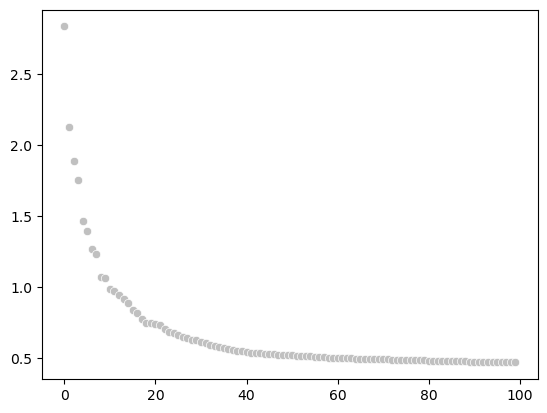

In [47]:
## Studying the RNA PC's

U1_init_an, S1_init_an, V1_init_an = np.linalg.svd(B, full_matrices = False)
plot_log_svda = np.log(S1_init_an[:100])
sns.scatterplot(data = plot_log_svda) 

In [48]:
## Correcting for the noise variance

k_B = 50
n_features_B = B.shape[1]
n_samples_B = B.shape[0]
B_residual = B-U1_init_an[:,:k_B] @ np.diag(S1_init_an[:k_B]) @ V1_init_an[:k_B,:]

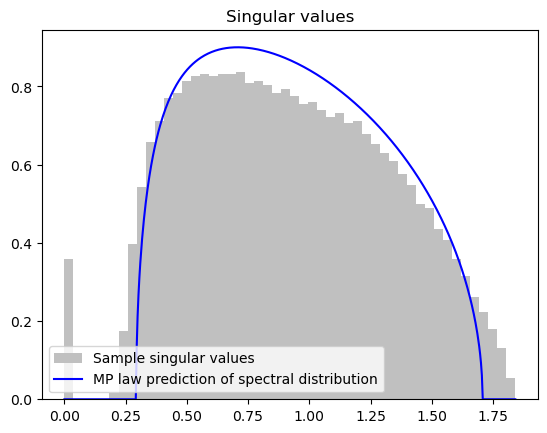

In [49]:

tau_sq_correct_B = np.sum(B_residual**2) / n_features_B
B_residual = B_residual/np.sqrt(tau_sq_correct_B)
U1_init_res_B, S1_init_res_B, V1_init_res_B = np.linalg.svd(B_residual, full_matrices = False)
fig, ax = plt.subplots()
sq_singular_val_B = S1_init_res_B 
shorter_side_B = min(n_samples_B, n_features_B)
ax.hist(sq_singular_val_B[:shorter_side_B], density = True, bins = 50, label = "Sample singular values")
x = np.linspace(sq_singular_val_B.min(), sq_singular_val_B.max(), num = 500)
aspect_ratio = n_features_B / n_samples_B
if aspect_ratio > 1:
    scaler = aspect_ratio
else:
    scaler = 1
ax.plot(x, scaler*np.array(sqrtMPlaw(x, n_samples_B, n_features_B)), label = "MP law prediction of spectral distribution")
ax.legend()
ax.set_title("Singular values") 
plt.show()

In [50]:
A_reduced = A
B_reduced = B / np.sqrt(tau_sq_correct_B)

In [51]:
## Aspect Ratios

gamma_1 = A_reduced.shape[1]/A_reduced.shape[0]
gamma_2 = B_reduced.shape[1]/B_reduced.shape[0]

In [52]:
## Compute Singular Value Decomposition of B

k_2 = 50

U2_init, S2_init, V2_init = sp.sparse.linalg.svds(B_reduced, k_2)
s_tilde = S2_init[0:k_2] / np.sqrt(gamma_2)
s_tilde = _convert_singular_val(s_tilde,gamma_2) 
S_tilde = np.diag(s_tilde)

sigma_y = (1 + gamma_2 * s_tilde ** 2) / (gamma_2 * s_tilde ** 2 * (s_tilde ** 2 + 1))
mu_y = np.sqrt(1 - sigma_y)
sigmabar_y = (1 + s_tilde ** 2) / (s_tilde ** 2 * (gamma_2 * s_tilde ** 2 + 1))
mubar_y = np.sqrt(1 - sigmabar_y)

# initialize M0 and Q0 for Y

M_0_y = np.diag(mu_y)
Sigma_0_y = np.diag(sigma_y)
M_bar_y = np.diag(mubar_y)
Sigma_bar_y = np.diag(sigmabar_y)

In [53]:
n = A_reduced.shape[0]; p_1 = A_reduced.shape[1]; p_2 = B_reduced.shape[1]

In [54]:
## Scaling of the singular vectors of A and B

F_x = A_reduced
U_x_t = F_x @ np.linalg.inv(L)

F_y = np.sqrt(n) * U2_init[:,:k_2]
G_y = np.sqrt(p_2) * V2_init.T[:,:k_2]

Gbar = G_y
U_y_t = F_y @ sp.linalg.sqrtm(Sigma_0_y)

In [55]:
## Store Raw PC's to run WNN

pc_x_for_seurat_with_pred = pd.DataFrame(U_A_adj[:,:30] @ np.diag(S_A_adj[:30]))
pc_x_for_seurat_with_pred.to_csv('pca_embeddings_for_seurat_integration_adt_rpcs.csv')
pc_y_for_seurat_with_pred = pd.DataFrame(F_y @ sp.linalg.sqrtm(Sigma_0_y))
pc_y_for_seurat_with_pred.to_csv('pca_embeddings_for_seurat_integration_rna_rpcs.csv')

In [56]:
meta_data_matrix = meta_harmony.to_numpy()
labels = np.array(meta_data_matrix[:,10:11])
labels = labels.flatten(order='C')

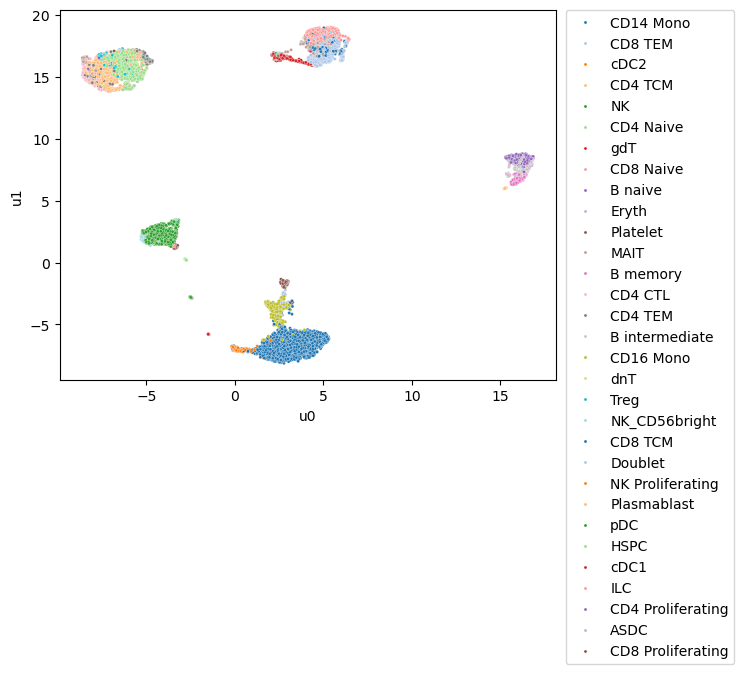

In [57]:
## Visulize UMAP without Data Integration

joint_embedding_PC = np.concatenate((U_x_t,U_y_t),axis=1)
u_pc_embedding = umap.UMAP().fit_transform(
        joint_embedding_PC )
umap_data_PC = pd.DataFrame({'u0': u_pc_embedding[:, 0], 'u1': u_pc_embedding[:, 1], 'label': labels})
sns.scatterplot(data=umap_data_PC, x='u0', y='u1', hue='label', palette= 'tab20', s = 5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## AMP Iteration

In [58]:
## Determine the support
M_bar_x = L
Sigma_bar_x = np.identity(L.shape[0])

n_clusters_u = int(np.round(np.cbrt(n)))
n_clusters_v = int(np.round(np.cbrt(p_2)))

#n_clusters_u = 25
#n_clusters_v = 8

#n_clusters_u = 25
#n_clusters_v_1 = 20
#n_clusters_v_2 = 20

data_prior_u = np.concatenate((F_x,F_y), axis=1)
means_prior_u = sp.linalg.block_diag(M_bar_x, M_bar_y)
cov_prior_u = sp.linalg.block_diag(Sigma_bar_x, Sigma_bar_y)

data_prior_v = G_y
means_prior_v = M_0_y
cov_prior_v = Sigma_0_y

In [59]:
n_clusters_u

22

In [60]:
# Example usage for v_x and v_y priors
k_max_v = max(10, int(np.cbrt(p_2)))

best_k_v_1, best_gmm_v_1, bics_v_1 = bic_gmm_grid_search(data_prior_v, k_min=1, k_max=k_max_v, random_state=seed)

mean_prior_comp_v = best_gmm_v_1.means_
cov_prior_comp_v = best_gmm_v_1.covariances_
weights_prior_comp_v = best_gmm_v_1.weights_

In [61]:
k_max_u = max(10, int(np.cbrt(n)))

bes_k_u, best_gmm_u, bics_u = bic_gmm_grid_search(data_prior_u, k_min=1, k_max=k_max_u, random_state=seed)

mean_prior_comp_u = best_gmm_u.means_
cov_prior_comp_u = best_gmm_u.covariances_
weights_prior_comp_u = best_gmm_u.weights_

In [62]:
mean_prior_comp_u[:,1]

array([-2.83320171,  5.71845149, -2.78436824, -2.92258737, -3.11652505,
       -0.88704439, -3.40578678, -0.93590722])

In [63]:
best_k_v_1, bes_k_u

(np.int64(4), np.int64(8))

In [64]:
# iterative refinement

max_iter = 10

M_y = np.array([M_0_y])
Sigma_y = np.array([Sigma_0_y])


for t in range(max_iter):
    
    # Denoising the right singular vectors
    
    V_y_t = denoise_gmm(Gbar, mean_prior_comp_v, cov_prior_comp_v, M_y, Sigma_y, weights_prior_comp_v)
     
    #print(V_x_t[0:5,0:5]); print(V_y_t[0:5,0:5])
    
    # Compute the Jacobians
    J_y = np.mean(ddenoise_gmm(Gbar, mean_prior_comp_v, cov_prior_comp_v, M_y, Sigma_y, weights_prior_comp_v), axis=0)
    
    # Substract the onsager terms
    Fbar = B_reduced.dot(V_y_t) - gamma_2 * U_y_t.dot(J_y.T)
    
    # Update State Evolution Parameters
    Sigmabar_y = (V_y_t.T @ V_y_t) / n
    if np.linalg.det(Sigmabar_y) <= 2.7e-05:
        np.fill_diagonal(Sigmabar_y, Sigmabar_y.diagonal() + np.finfo('float32').eps)
    Mbar_y = Sigmabar_y * s_tilde

    Mbar = np.array([L, Mbar_y], dtype=object)
    Sigmabar = np.array([Sigma_bar_x,Sigmabar_y], dtype=object)
    F_comb = np.concatenate((A_reduced, Fbar), axis=1)
    
    # Denoise left singular vectors in a orchestrated manner
    U = denoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)
    U_x_t = U[:,:k_A]
    U_y_t = U[:,k_A:]
    
    J_comb = ddenoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)
    
    # Compute the Jacobians
    J_2 = np.mean(J_comb[:,k_A:,k_A:], axis = 0)

    # Substract the onsager terms
    Gbar = (B_reduced.T).dot(U_y_t) - V_y_t.dot(J_2.T)
    
    # Update State Evolution Parameters
    Sigma_y = (U_y_t.T @ U_y_t) / n
    if np.linalg.det(Sigma_y) <= 2.7e-05:
        np.fill_diagonal(Sigma_y, Sigma_y.diagonal() + np.finfo('float32').eps)
    M_y = Sigma_y * s_tilde

    M_y = np.array([M_y])
    Sigma_y = np.array([Sigma_y])
    
    print(f"The current iteration is {t}")
   
    ## Update the priors and the support if needed

    ### pi_single_v_x = estimate_prior_single(G, supp_x_v, M_x, Sigma_x, 10)
    ### pi_single_v_y = estimate_prior_single(Gbar, supp_y_v, M_y, Sigma_y, 10)
    ### pi_joint_u = estimate_prior_joint(F, Fbar, supp_x_u, supp_y_u, Mbar_x, Mbar_y, Sigmabar_x, Sigmabar_y, 10)
    ### supp_x_u = extract_support(F, n_clusters_u, Mbar_x)
    ### supp_y_u = extract_support(Fbar, n_clusters_u, Mbar_y)

    ### supp_x_v = extract_support(G, n_clusters_u, M_x)
    ### supp_y_v = extract_support(Gbar, n_clusters_u, M_y)

The current iteration is 0
The current iteration is 1
The current iteration is 2
The current iteration is 3
The current iteration is 4
The current iteration is 5
The current iteration is 6
The current iteration is 7
The current iteration is 8
The current iteration is 9


In [65]:
U_x_t[1:3,:5]

array([[ 1.53885766,  0.28851524,  0.39564952, -0.62320557,  0.19732745],
       [-1.12992649, -0.06616889,  1.34798714, -0.69050678, -0.14939711]])

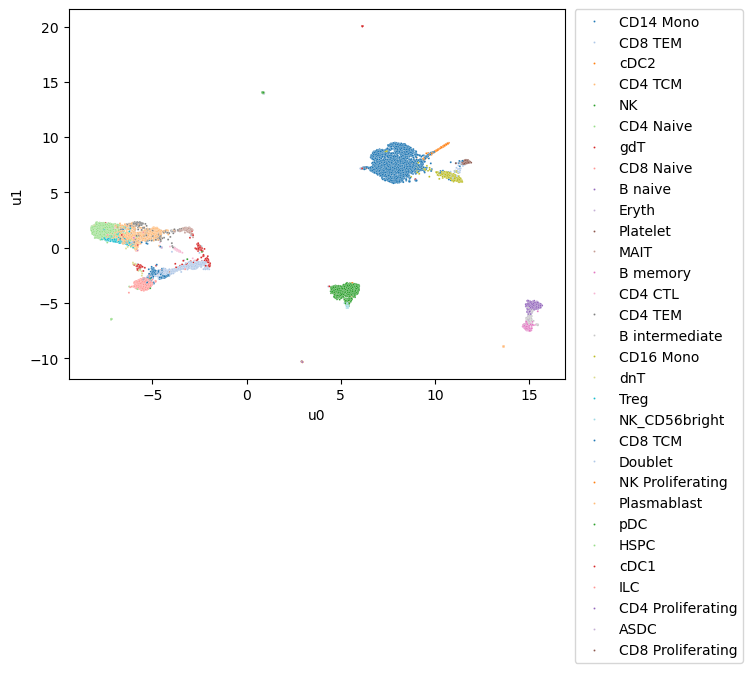

In [66]:
## UMAP visualization of the atlas

joint_embedding_amp = np.concatenate((U_x_t,U_y_t),axis=1)
amp_for_pred = pd.DataFrame(joint_embedding_amp)
amp_for_pred.to_csv('orchamp_embeddings_integrated_50_rpcs.csv')
u_joint_embedding = umap.UMAP().fit_transform(
        joint_embedding_amp)
umap_data = pd.DataFrame({'u0': u_joint_embedding[:, 0], 'u1': u_joint_embedding[:, 1], 'label': labels})
sns.scatterplot(data=umap_data, x='u0', y='u1', hue='label', palette= 'tab20', s = 2)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [67]:
labels_modified_store = pd.DataFrame(labels)
labels_modified_store.to_csv('labels_modified_50_rpcs.csv')
